# author Giovambattista Vieri
# (c) 2020 all rights reserverd
# license: GPL V 2.0 
# 


In [1]:
!pip install numpy==1.18.1
!pip install beautifultable==0.8.0
!pip install matplotlib
!pip install GitPython==3.1.0


In [0]:
from git import Repo
from os import listdir 
import csv
import os
import sys
import shutil
import argparse 
import numpy as np
from beautifultable import BeautifulTable
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from matplotlib.ticker import MaxNLocator



In [0]:
register_matplotlib_converters()
destdir="covid19"
searchdir=destdir+"/csse_covid_19_data/csse_covid_19_daily_reports"


In [0]:
def firstfilelayout(row):
# it will receive a row in argument: with first line (header) skipped. 
    confirmed=deaths=recovered=0
    if len(row[3])<1: row[3]=0
    if len(row[4])<1: row[4]=0
    if len(row[5])<1: row[5]=0
    confirmed +=int(row[3])
    deaths    +=int(row[4])
    recovered +=int(row[5])
    return(confirmed,deaths,recovered)

def secondfilelayout(row):
# it will receive a row in argument: with first line (header) skipped. 
    confirmed=deaths=recovered=0
    if len(row[7])<1: row[7]=0
    if len(row[8])<1: row[8]=0
    if len(row[9])<1: row[9]=0
    confirmed +=int(row[7])
    deaths    +=int(row[8])
    recovered +=int(row[9])
    return(confirmed,deaths,recovered)



In [0]:
def processafile(filename):
    completefile=searchdir+"/"+filename
    confirmed=deaths=recovered=0
    with open(completefile,'r') as fi:
        reader=csv.reader(fi)
        headers=next(reader)
        for row in reader:
            if 'FIPS' in headers[0]:
                res=secondfilelayout(row)
            else:
                res=firstfilelayout(row)
            confirmed +=int(res[0])
            deaths    +=int(res[1])
            recovered +=int(res[2])

    return(confirmed,deaths,recovered)


In [0]:
ratio     =True
save      =False
chart     =True
grid      =True
nicetable =True
logyscale =True


In [0]:
if os.path.isdir(destdir):
  shutil.rmtree(destdir)

os.mkdir(destdir)

Repo.clone_from("https://github.com/CSSEGISandData/COVID-19",destdir)

ext='csv' 

filenames=listdir(searchdir)
filenames.sort()
orig_stdout=sys.stdout

if nicetable: 
  table=BeautifulTable()
  if ratio:
    header=["date","Confirmed","Death","Recovered","Death/Conf", "Recovered/Conf"]
  else:
    header=["date","Confirmed","Death","Recovered"]
  table.column_headers=header
  if save:
    fo=open('out.csv','w')
    sys.stdout=fo


In [8]:
content=[]
for filename in filenames:
  if filename.endswith(ext):
    r=list(processafile(filename) )
    tablerow=[]
    if r[1] >0:
      r.append(float(r[1]/r[0]))
    else:
      r.append('NaN')
    if r[2] >0:
      r.append(float(r[2]/r[0]))
    else:
      r.append('NaN')

    if nicetable: 
      if ratio:
        tablerow=[filename[:-4],r[0],r[1],r[2],r[3],r[4]] 
      else: 
        tablerow=[filename[:-4],r[0],r[1],r[2]] 
      table.append_row(tablerow)
    else:
      if ratio:
        print("{},{},{},{},{:.3f},{:.3f}".format(filename[:-4],r[0],r[1],r[2],r[3],r[4]) )
      else: 
        print("{},{},{},{}".format(filename[:-4],r[0],r[1],r[2]) )
    content.append([filename[:-4],r[0],r[1],r[2]])
    
if nicetable:
  print(table)





+------------+-----------+-------+-----------+------------+----------------+
|    date    | Confirmed | Death | Recovered | Death/Conf | Recovered/Conf |
+------------+-----------+-------+-----------+------------+----------------+
| 01-22-2020 |    555    |  17   |    28     |   0.031    |      0.05      |
+------------+-----------+-------+-----------+------------+----------------+
| 01-23-2020 |    653    |  18   |    30     |   0.028    |     0.046      |
+------------+-----------+-------+-----------+------------+----------------+
| 01-24-2020 |    941    |  26   |    36     |   0.028    |     0.038      |
+------------+-----------+-------+-----------+------------+----------------+
| 01-25-2020 |   1438    |  42   |    39     |   0.029    |     0.027      |
+------------+-----------+-------+-----------+------------+----------------+
| 01-26-2020 |   2118    |  56   |    52     |   0.026    |     0.025      |
+------------+-----------+-------+-----------+------------+----------------+

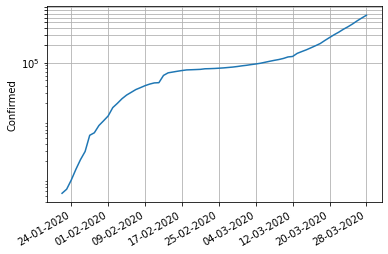

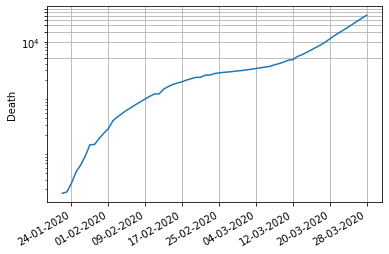

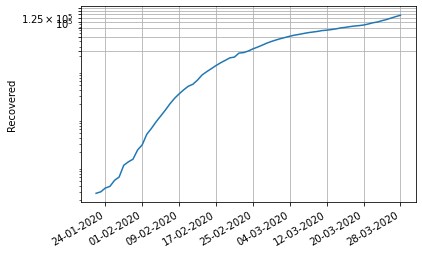

In [9]:

if save:
  sys.stdout=orig_stdout
  fo.close()


if chart:
 # plt.gca().xaxis_date()
  
  dummy=np.array(content)
  d=dummy[:,0]
  days=[dt.datetime.strptime(d,'%m-%d-%Y').date() for d in d]
  datefile=dt.datetime.today().strftime('%Y%m%d')
    ###### make chart of confirmed
  
  plt.figure()
  plt.ylabel('Confirmed') 
  confirmed=np.array(dummy[:,1],dtype=int)
  if logyscale:
    plt.yscale('log')
  plt.plot(days,confirmed)

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
  plt.gca().xaxis.set_major_locator( MaxNLocator(nbins = 10) )
  plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 10) )
  plt.gcf().autofmt_xdate()
  if grid:
    plt.grid()
  plt.savefig('Confirmed'+datefile)
  plt.show()

    ###### make chart of Deaths
  death=np.array(dummy[:,2],dtype=int)
  plt.figure()
  plt.ylabel('Death') 
  if logyscale:
    plt.yscale('log')
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
  plt.plot(days,death)
  plt.gca().xaxis.set_major_locator( MaxNLocator(nbins = 10) )
  plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 10) )
  plt.gcf().autofmt_xdate()
  if grid:
    plt.grid()
  plt.savefig('Death'+datefile)
#        plt.show()


    ###### make chart of Recoverred
  recovered=np.array(dummy[:,3],dtype=int)
  plt.figure()
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
  plt.ylabel('Recovered') 
  if logyscale:
    plt.yscale('log')
  confirmed=dummy[:,1]
  plt.plot(days,recovered)
  plt.gca().xaxis.set_major_locator( MaxNLocator(nbins = 10) )
  plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 10) )
  if grid:
    plt.grid()
  plt.gcf().autofmt_xdate()
  plt.savefig('Recovered'+datefile)
#        plt.show()
